# Discover and Read EO data - Exercise 1



You have seen how to access the EO data from EODC using the STAC API. Your task now is to find Sentinel-1 Sigma Nought backscatter data from the EODC. Find data which is:

- Closest to your time and location of birth
- Closest to your last holiday

### Planned Approach
- Take new collection
- Filter spatially and temporally
- Find available metadata, like ground sampling distance (GSD), polarisations, wavelength of the microwave sensor, resolution, etc.

In [1]:
import pystac_client
import odc.stac
from rasterio.crs import CRS

#### List all collection names and select one

In [2]:
collections = pystac_client.Client.open(
    "https://stac.eodc.eu/api/v1").get_collections()

max_length = max(len(collection.id) for collection in collections)

for collection in pystac_client.Client.open(
        "https://stac.eodc.eu/api/v1").get_collections():
    print(f"{collection.id.ljust(max_length)} : {collection.title}")

SENTINEL2_L2A                     : Sentinel-2 MSI Products: Level-2A data
SENTINEL2_GRI_L1C                 : Multi-Layer Copernicus Sentinel-2 GRI in L1C
DOP_AUT_K_OSTTIROL                : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Osttirol
SENTINEL1_HPAR                    : SENTINEL1 Harmonic Parameters
AUT_DEM                           : Austrian High Resolution DEM
COP_DEM                           : Copernicus Digital Elevation Model (DEM)
DOP_AUT_K_KLAGENFURT              : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Klagenfurt
DOP_AUT_K_WOLFSBERG               : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Wolfsberg
SENTINEL1_MPLIA                   : SENTINEL1 Mean PLIA
SENTINEL1_SLC                     : Sentinel-1 SLC
SENTINEL1_GRD                     : Sentinel-1 SAR L1 GRD
AI4SAR_SIG0                       : AI4SAR Despeckled Sentinel-1 Sigma0 (20m)
SENTINEL3_SRAL_L2                 : Sentin

In [3]:
collection = pystac_client.Client.open(
    "https://stac.eodc.eu/api/v1").get_collection('SENTINEL1_SIG0_20M')
collection

<CollectionClient id=SENTINEL1_SIG0_20M>

#### Define spatial and temporal extent and use client to load the metadata

In [4]:
latmin, latmax = 63.5, 65
lonmin, lonmax = -22.5, -20
bounds = (lonmin, latmin, lonmax, latmax)

time_range = "2022-01-20/2022-02-10"

items = pystac_client.Client.open("https://stac.eodc.eu/api/v1").search(
    bbox=bounds,
    collections=collection,
    datetime=time_range,
    limit=100,
).item_collection()

print(len(items), 'scenes found.')

69 scenes found.


#### Find necessary metadata, like bands, resolution, coordinate reference system

In [5]:
items[0]

<Item id=SIG0_20220209T185134_A118_E039N039T3_EU020M_V1M1R1_S1AIWGRDH>

In [6]:
resolution = items[0].properties['sar:resolution_range']
epsg = CRS.from_epsg(27704)

#### Check available assets or bands in the STAC item

In [7]:
available_assets = items[0].assets
available_assets

{'VH': <Asset href=https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E039N039T3/SIG0_20220209T185134__VH_A118_E039N039T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif>,
 'VV': <Asset href=https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E039N039T3/SIG0_20220209T185134__VV_A118_E039N039T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif>,
 'thumbnail': <Asset href=https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E039N039T3/SIG0_20220209T185134__VV_A118_E039N039T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif/thumbnail>}

#### Lazily load the data into a Dask array

In [19]:
sig0_dc = odc.stac.stac_load(
    items,
    bbox=bounds,
    chunks={'time': 5, 'x': 600, 'y': 600},
    crs="EPSG:4326",
    resolution=resolution / 111320,  # conversion from m to degrees
    )

sig0_dc

<xarray.Dataset> Size: 5GB
Dimensions:      (latitude: 4175, longitude: 6958, time: 44)
Coordinates:
  * latitude     (latitude) float64 33kB 65.0 65.0 65.0 65.0 ... 63.5 63.5 63.5
  * longitude    (longitude) float64 56kB -22.5 -22.5 -22.5 ... -20.0 -20.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 352B 2022-01-21T05:49:16 ... 2022-02-0...
Data variables:
    VH           (time, latitude, longitude) int16 3GB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    VV           (time, latitude, longitude) int16 3GB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>

#### Define the nodata value and scale factor if `stac_load` didn't include it

In [16]:
nodata = items[0].assets['VV'].extra_fields['raster:bands'][0]['nodata']
scale = items[0].assets['VV'].extra_fields['raster:bands'][0]['scale']

sig0 = (sig0_dc.where(sig0_dc != nodata) / scale).VV
sig0

<xarray.DataArray 'VV' (time: 44, latitude: 4175, longitude: 6958)> Size: 5GB
dask.array<truediv, shape=(44, 4175, 6958), dtype=float32, chunksize=(5, 600, 600), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 33kB 65.0 65.0 65.0 65.0 ... 63.5 63.5 63.5
  * longitude    (longitude) float64 56kB -22.5 -22.5 -22.5 ... -20.0 -20.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 352B 2022-01-21T05:49:16 ... 2022-02-0...

#### Plot the loaded data

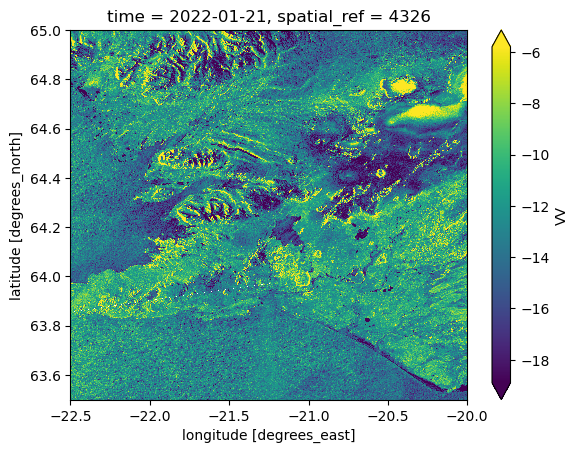

In [17]:
sig0 = sig0.resample(time='1D').max()
sig0.sel(time="2022-01-19", method="nearest").plot.imshow(robust=True)